## keras_merge_3_app_predict
使用异常图片检测时top50-top100选出的，且没放入训练集的图片，验证模型的鲁棒性  
模型使用：Merge-tuning-2-v2.h5  
异常图片目录：data/anormal/diff,下面含cat和dog目录：  
- cat目录下有6张图片没放入训练集
- dog目录下全部没有放入训练集


In [1]:
'''
数据目录结构：
data/
    anormal/  #top50-top100选出的异常图片
        diff/  
           dog/  #9张图片
            dog.10161.jpg
            dog.10747.jpg
            ...
         cat/   #56张图片
            cat.10037.jpg
            cat.10270.jpg
            ...
'''
import cv2
import time
import pandas as pd
from tqdm import tqdm   #进度条
from PIL import Image
from helper import *

from keras.models import *
from keras.layers import *
from keras.applications import *
from keras.preprocessing.image import *
from keras.utils import *
from sklearn.utils import shuffle

test_data_dir='data/anormal/diff'
#prep_data_process调用move_anormal_images函数得知下面列表
cat_list_file=['cat/cat.7291.jpg','cat/cat.7372.jpg','cat/cat.6655.jpg',
               'cat/cat.10365.jpg','cat/cat.7703.jpg','cat/cat.12476.jpg']

#模型权重文件
model_h5file="Merge-tuning-2-v2.h5"  

/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/matplotlib/__init__.py:1067: UserWarning: Duplicate key in file "/home/ubuntu/.config/matplotlib/matplotlibrc", line #2
  (fname, cnt))
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/matplotlib/__init__.py:1067: UserWarning: Duplicate key in file "/home/ubuntu/.config/matplotlib/matplotlibrc", line #3
  (fname, cnt))
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
#保存特征向量，这里只需要提取需要测试的图片的特征向量
def write_feature_data(MODEL, image_shape, weights_file, preprocess_input = None):
    input_tensor = Input((image_shape[0], image_shape[1], 3))
    x = input_tensor
    if preprocess_input:
        x = Lambda(preprocess_input)(x)
    
    base_model = MODEL(input_tensor=x, weights=weights_file, include_top=False, pooling = 'avg')

    gen = ImageDataGenerator()
    test_generator = gen.flow_from_directory(test_data_dir, image_shape, shuffle=False, 
                                             batch_size=8, class_mode=None) #因为图片很少，所以batch_size设成8
    print(test_generator.samples)

    test_feature = base_model.predict_generator(test_generator, test_generator.samples, verbose=1)
    
    with h5py.File("test_feature_%s.h5"%base_model.name) as h:
        h.create_dataset("test", data=test_feature)
        

In [3]:
#用三个模型fine-tuning时，预测结果最好的权重文件提取特征向量
write_feature_data(ResNet50, (224, 224), "no_top_ResNet50-fine-tuning-3-v1.h5",  preprocess_input = resnet50.preprocess_input)
print("get ResNet50 freature over!")
write_feature_data(Xception, (299, 299), "no_top_xception-fine-tuning-1.h5",  preprocess_input = xception.preprocess_input)
print("get Xception freature over!")
write_feature_data(InceptionResNetV2, (299, 299), "no_top_InceptonResNetV2-fine-tuning-2-v2.h5",  preprocess_input = inception_resnet_v2.preprocess_input)
print("get InceptionResNetV2 freature over!")

Found 65 images belonging to 2 classes.
65
65/65 [==============================] - 44s 676ms/step
get ResNet50 freature over!
Found 65 images belonging to 2 classes.
65
65/65 [==============================] - 13s 197ms/step
get Xception freature over!
Found 65 images belonging to 2 classes.
65
65/65 [==============================] - 23s 357ms/step
get InceptionResNetV2 freature over!


In [2]:
#从文件中读取特征向量和标签
np.random.seed(2018)

X_train = []
X_test = []

for filename in ["test_feature_resnet50.h5", "test_feature_xception.h5", "test_feature_inception_resnet_v2.h5"]:
    with h5py.File(filename, 'r') as h:
        X_test.append(np.array(h['test']))
        
X_test = np.concatenate(X_test, axis=1)


In [3]:
#最优实验对应的模型
input_tensor = Input(X_test.shape[1:])

x = Dropout(0.5)(input_tensor)
x = Dense(1, activation='sigmoid', kernel_regularizer=regularizers.l2(0.001))(x)
model2 = Model(input_tensor, x)

adam = optimizers.Adam(lr=1e-5, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False) #训练快,把lr设置小一点
model2.compile(optimizer=adam,
             loss='binary_crossentropy',
             metrics=['accuracy'])

471/471 [==============================] - 0s 53us/step
Found 65 images belonging to 2 classes.
cat.10365.jpg [98.365166]% cat


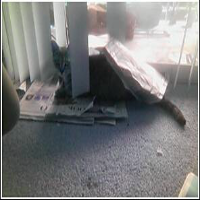

cat.12476.jpg [97.702446]% cat


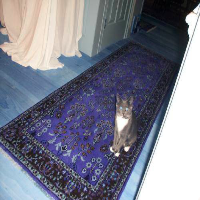

cat.6655.jpg [56.06873]% unsure


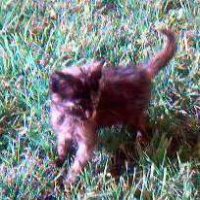

cat.7291.jpg [99.90767]% cat


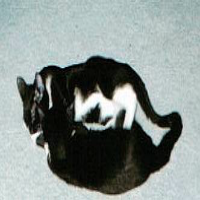

cat.7372.jpg [99.973976]% cat


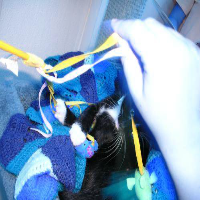

cat.7703.jpg [85.7739]% cat


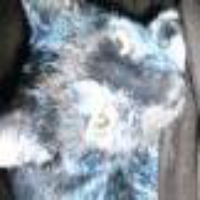

dog.10161.jpg [59.297997]% unsure


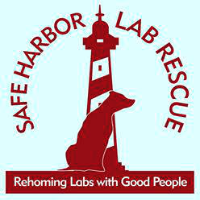

dog.10747.jpg [57.243294]% unsure


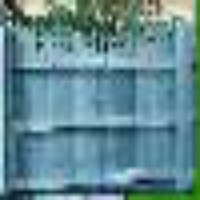

dog.11266.jpg [99.62495]% dog


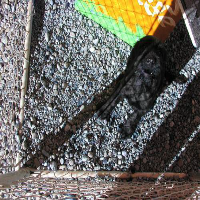

dog.1259.jpg [40.20211]% unsure


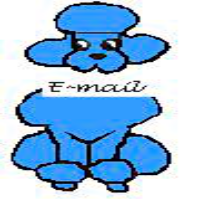

dog.1773.jpg [91.0217]% dog


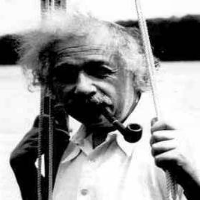

dog.2422.jpg [98.47311]% dog


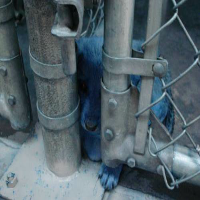

dog.3889.jpg [99.87318]% dog


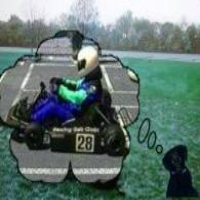

dog.6475.jpg [85.66483]% dog


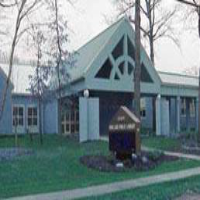

dog.8898.jpg [52.008842]% unsure


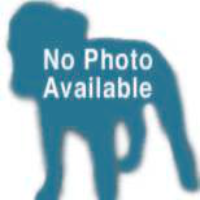

In [5]:
#预测
model2.load_weights(model_h5file)
y_test = model2.predict(X_test, verbose=1)
    
gen = ImageDataGenerator()
test_generator = gen.flow_from_directory(test_data_dir, (224, 224), shuffle=False, 
                                         batch_size=8, class_mode=None)

for i, fname in enumerate(test_generator.filenames):
    if fname[:3] == 'cat' and fname not in cat_list_file:
        continue
    if  y_test[i]>=0.6:
        print("{} {}% dog".format(fname[4:], y_test[i]*100))
    elif y_test[i] <= 0.4:
        print("{} {}% cat".format(fname[4:], 100*(1.0-y_test[i])))
    else:
        print("{} {}% unsure".format(fname[4:], y_test[i]*100))
    fullname='data/anormal/diff/'+fname
    x = cv2.imread(fullname) 
    x = cv2.resize(x, (200, 200))  
    img = array_to_img(x)
    display(img)
